https://github.com/facebookresearch/fairseq/tree/main/examples/roberta/commonsense_qa#3-evaluate

# NLP FS25 Course Project 2: Commensense Question Answering with Transformers

By David Hodel

Weighs & Biases Project: https://wandb.ai/dhodel-hslu-nlp/hslu-fs25-nlp-qa-transformers

## Introduction

In this notebook, I present my solution to the second course project of the FS25 NLP module at HSLU.

The task is to compare three Transformer models on the task of commonsense question answering:
1) A randomly initialized Transformer
2) A pre-trained Transformer (which was not trained / finetuned on CommonsenseQA)
3) An LLM (1B+ parameters) of my choice

I'll finetune the first two models and do prompt-engineering for the LLM. The goal is to compare the performance of these three models on the task of commonsense question answering.

### Dataset

We use the CommonsenseQA ([Talmor et al., 2019](https://aclanthology.org/N19-1421/)) dataset in this project. The dataset consists of 12,247 questions with 5 choices each, where only one is correct. The questions are designed to require commonsense reasoning to answer correctly.

The dataset was created by taking concepts from ConceptNet, a semantic network of commonsense knowledge.

## Setup

We first import the necessary libraries to run the code.

In [1]:
from collections import Counter
from datetime import datetime
import random
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torcheval.metrics as metrics
from torch.utils.data import Dataset

import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import AutoModelForCausalLM, pipeline

import wandb

We set up a fixed random seed to (at least try to) ensure reproducibility.

In [2]:
SEED = 42
seed_everything(SEED, workers=True)

Seed set to 42


42

Since we use Weights & Biases for experiment tracking, we first have to log in to our account.

In [ ]:
wandb.login()
api = wandb.Api()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: davidhodel (dhodel-hslu-nlp) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


If we don't want to run a full hyperparameter search, we can set the id of an existing sweep to load the results from.

In [20]:
existing_sweep_id = "ef45hou8"
existing_random_initialized_model_run_id = "95gtdhkj"
existing_llm_run_id = "hxgu5yfh"

In [17]:
# set TOKENIZERS_PARALLELISM= false to avoid warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### Data Splits

The data is available on Hugging Face: https://huggingface.co/datasets/tau/commonsense_qa.
Since only the train and validation splits have an answer key, we will use our own dataset splits.
We perform the splitting as presented in the lecture slides: We separate the last 1"000 samples from the training set as the validation set and use the original validation set as the test set.

In [5]:
train = load_dataset("tau/commonsense_qa", split="train[:-1000]")
valid = load_dataset("tau/commonsense_qa", split="train[-1000:]")
test = load_dataset("tau/commonsense_qa", split="validation")

print(len(train), len(valid), len(test))

8741 1000 1221


## Data Exploration

First, we want to take a look at the data to understand its structure and content.

In [80]:
datasets = {
  "train": train,
  "validation": valid,
  "test": test
}

We ensure that all three splits have the same structure and that the answers are in the same format.

In [81]:
print(train.column_names)
assert train.column_names == valid.column_names == test.column_names

print(train[0])

unique_answers = set([ex["answerKey"] for ex in train] + [ex["answerKey"] for ex in valid] + [ex["answerKey"] for ex in test])
print(f"Unique answer keys: {unique_answers}")

assert len(unique_answers) == 5

['id', 'question', 'question_concept', 'choices', 'answerKey']
{'id': '075e483d21c29a511267ef62bedc0461', 'question': 'The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?', 'question_concept': 'punishing', 'choices': {'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['ignore', 'enforce', 'authoritarian', 'yell at', 'avoid']}, 'answerKey': 'A'}
Unique answer keys: {'E', 'A', 'D', 'B', 'C'}


We then display a sample question and its answer for each split to get a feeling of the type of questions and answers.

In [82]:
for split, data in datasets.items():
    print(f"\n=== {split} Split ===")
    print(f"Question: {data[0]['question']}")
    for j, choice in enumerate(data[0]['choices']['text']):
        print(f"{chr(65+j)}) {choice}")  # A, B, C, etc.
    print(f"Correct Answer: {data[0]['answerKey']}")
    print("=" * 50)


=== train Split ===
Question: The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?
A) ignore
B) enforce
C) authoritarian
D) yell at
E) avoid
Correct Answer: A

=== validation Split ===
Question: What is a well known way for couples  of celebrating a marriage?
A) eat cake
B) getting drunk
C) having sex
D) cleaning rooms
E) drink too much
Correct Answer: C

=== test Split ===
Question: A revolving door is convenient for two direction travel, but it also serves as a security measure at a what?
A) bank
B) library
C) department store
D) mall
E) new york
Correct Answer: A


We plot the distribution of answer key across the three splits to see if there are any imbalances in the data.

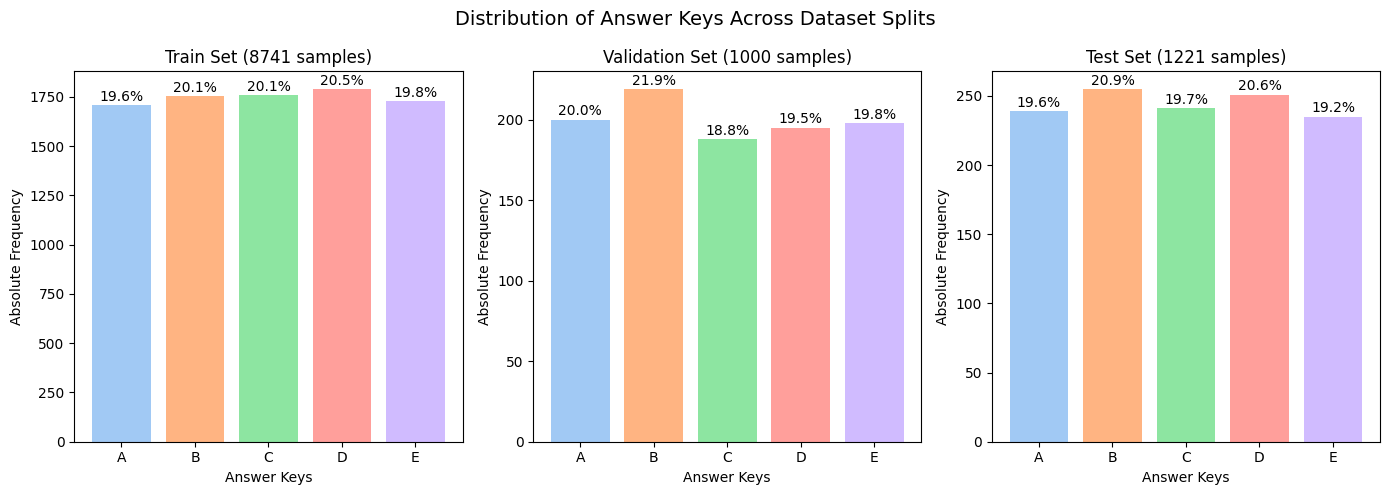

In [83]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5))

labels = sorted(list(unique_answers))

colors = sns.color_palette("pastel")[0:5]

for i, (split, data) in enumerate(datasets.items()):
    answer_counts = Counter([ex["answerKey"] for ex in data])
    
    # Sort by labels to ensure consistent order
    counts = [answer_counts[label] for label in labels]
    
    ax[i].bar(labels, counts, color=colors)
    ax[i].set_xlabel("Answer Keys")
    ax[i].set_ylabel("Absolute Frequency")
    ax[i].set_title(f"{split.capitalize()} Set ({len(data)} samples)")
    
    # Add percentage annotations
    total = sum(counts)
    for j, count in enumerate(counts):
        percentage = count / total * 100
        ax[i].annotate(f"{percentage:.1f}%", 
                      xy=(labels[j], count),
                      xytext=(0, 3),
                      textcoords="offset points",
                      ha='center')

plt.suptitle("Distribution of Answer Keys Across Dataset Splits", fontsize=14)
plt.tight_layout()

We see that the distribution is relatively balanced, with a slight preference for answer `B` in the validation and test set.

We also plot the distribution of the number of characters in the questions.

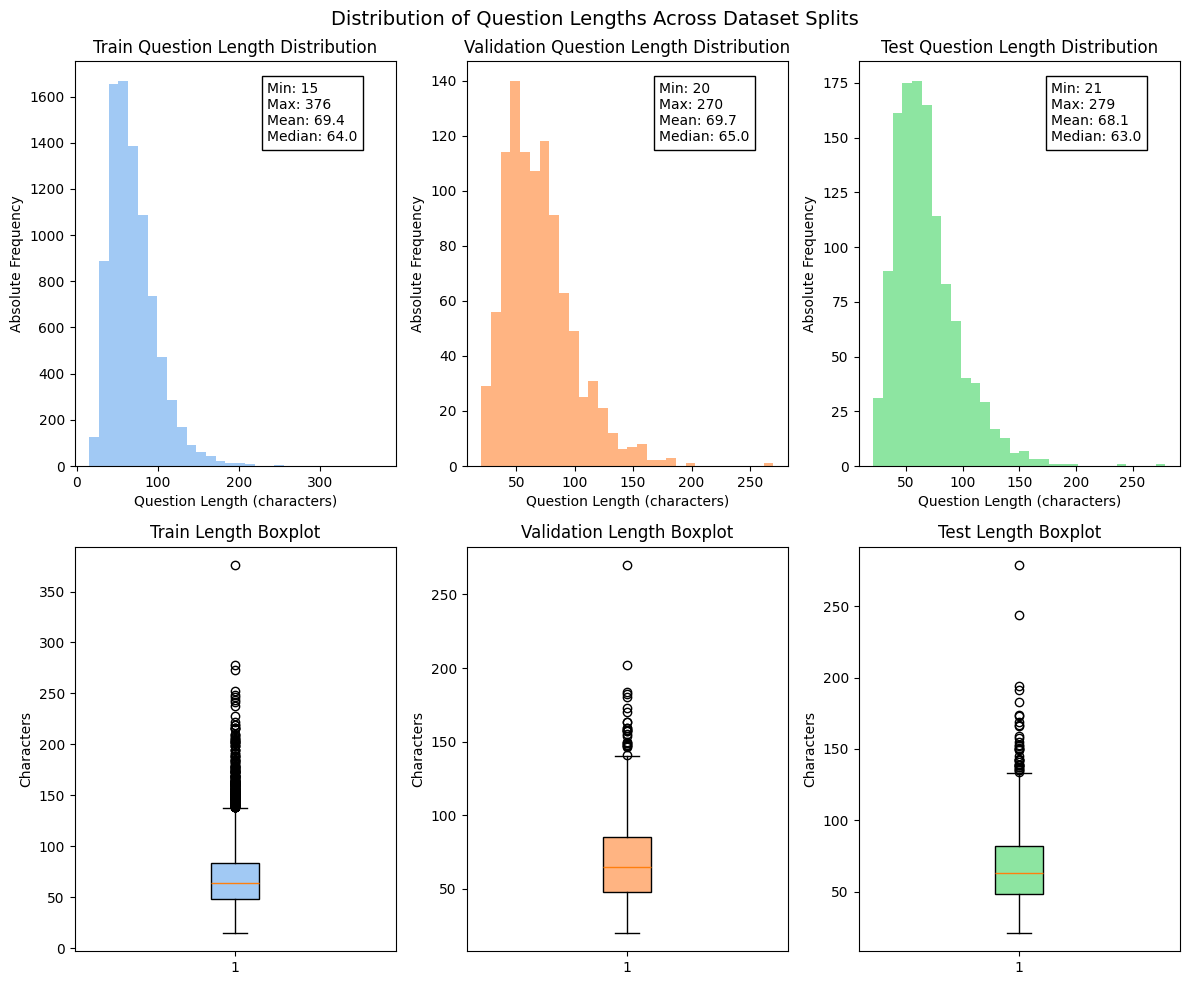

In [84]:
fig, axes = plt.subplots(2, 3, figsize=(12, 10))

colors = sns.color_palette("pastel")[0:3]
all_question_lengths = []

for i, (split, data) in enumerate(datasets.items()):
  question_lengths = [len(ex["question"]) for ex in data]
  all_question_lengths.append(question_lengths)
  
  # Histogram plots (top row)
  axes[0, i].hist(question_lengths, bins=30, color=colors[i])
  axes[0, i].set_xlabel("Question Length (characters)")
  axes[0, i].set_ylabel("Absolute Frequency")
  axes[0, i].set_title(f"{split.capitalize()} Question Length Distribution")
  
  # Add statistics as text
  axes[0, i].text(0.6, 0.95, 
      f"Min: {min(question_lengths)}\nMax: {max(question_lengths)}\nMean: {np.mean(question_lengths):.1f}\nMedian: {np.median(question_lengths)}",
      transform=axes[0, i].transAxes,
      bbox=dict(facecolor='white'),
      verticalalignment='top')
  
  # Boxplot (bottom row)
  axes[1, i].boxplot(question_lengths, patch_artist=True)
  axes[1, i].set_title(f"{split.capitalize()} Length Boxplot")
  axes[1, i].set_ylabel("Characters")
  
  # Set the boxplot fill color
  for patch in axes[1, i].get_children():
    if isinstance(patch, plt.matplotlib.patches.PathPatch):
      patch.set_facecolor(colors[i])

plt.suptitle("Distribution of Question Lengths Across Dataset Splits", fontsize=14)
plt.tight_layout()

We see that the questions are relatively short, with most of them having less than 100 characters. The three splits have a similar distribution and similar mean and median values.

The longest question has 376 characters which is good managable for both the Transformer model and the LLM.

We do the same check for the question choices and see that the distribution is similar to the questions. The longest question choice has 143 characters which is also manageable for both the Transformer model and the LLM.

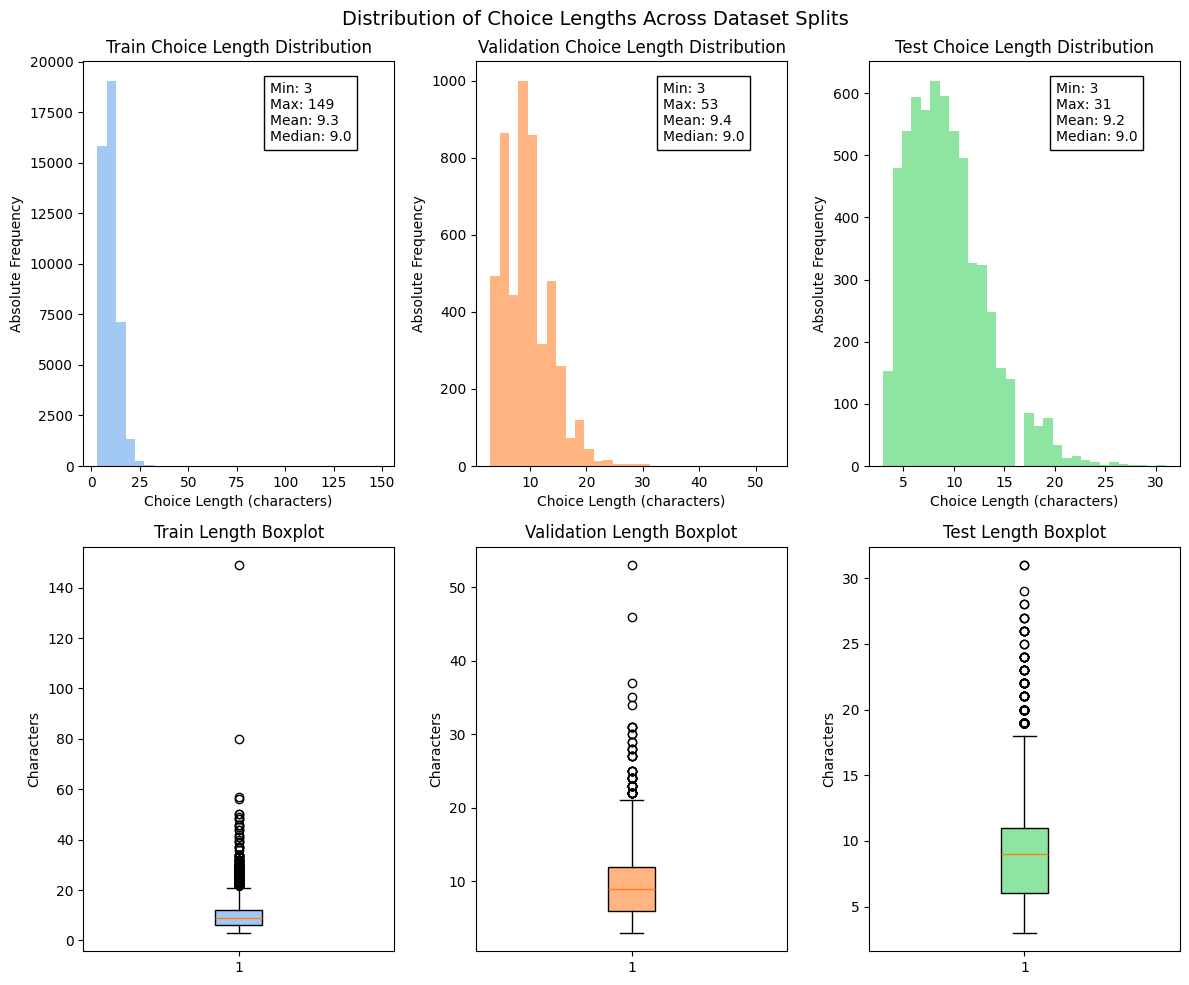

In [85]:
fig, axes = plt.subplots(2, 3, figsize=(12, 10))

colors = sns.color_palette("pastel")[0:3]
all_choice_lengths = []

for i, (split, data) in enumerate(datasets.items()):
  choice_lengths = np.array([[len(choice) for choice in ex["choices"]["text"]] for ex in data]).flatten()
  all_choice_lengths.append(choice_lengths)
  
  # Histogram plots (top row)
  axes[0, i].hist(choice_lengths, bins=30, color=colors[i])
  axes[0, i].set_xlabel("Choice Length (characters)")
  axes[0, i].set_ylabel("Absolute Frequency")
  axes[0, i].set_title(f"{split.capitalize()} Choice Length Distribution")
  
  # Add statistics as text
  axes[0, i].text(0.6, 0.95, 
      f"Min: {min(choice_lengths)}\nMax: {max(choice_lengths)}\nMean: {np.mean(choice_lengths):.1f}\nMedian: {np.median(choice_lengths)}",
      transform=axes[0, i].transAxes,
      bbox=dict(facecolor='white'),
      verticalalignment='top')
  
  # Boxplot (bottom row)
  axes[1, i].boxplot(choice_lengths, patch_artist=True)
  axes[1, i].set_title(f"{split.capitalize()} Length Boxplot")
  axes[1, i].set_ylabel("Characters")
  
  # Set the boxplot fill color
  for patch in axes[1, i].get_children():
    if isinstance(patch, plt.matplotlib.patches.PathPatch):
      patch.set_facecolor(colors[i])

plt.suptitle("Distribution of Choice Lengths Across Dataset Splits", fontsize=14)
plt.tight_layout()

## Preprocessing

No real preprocessing is needed for the data.
The DistilRoBERTa model supports any english text, including lowercase / uppercase, punctuation, etc.

Same goes for the Phi-LLM, which also accepts any english text.

We don't lowercase the text as it may contain important information such as `I` or `US` and because both models and its tokenizers are case-sensitive.

We also don't remove stopwords or punctuation as they may also contain important information for the model for answering the questions.

Stemming or lemmatization is not necessary the word embeddings and the models can handle different forms of words. Even more, it may be counterproductive as it may remove important information from the text such as time or location information.

Removal of unknown words is not necessary as fasttext word vectors are built from vectors of substrings of characters contained in it. This allows to build vectors even for misspelled words or concatenation of words.

As the longest question only has 376 characters, we don't need to truncate the text. During training we will use padding to ensure all inputs in a batch have the same length.

The text in the dataset is already clean and doesn't contain any html tags we would need to remove and / or parse. 

### Input Formats

#### Transformer

For each question I construct five inputs, one for each of the five answer choices.
Each input is constructed by concatenating the question and candidate answer.
The questions are prefixed with "Q: " and the answer choices are prefixed with "A: ".

So one input to the Transformer looks like this: `<s>Q: <question></s><s>A: <answer choice></s>`.

#### LLM

The LLM receives the question and answer choices in a textual format formatted for the Hugging Face pipeline.
The `user` prompt contains the question and all 5 answer choices in the following format:

```
Question: <question>
Choices:
A <answer choice A>
B <answer choice B>
C <answer choice C>
D <answer choice D>
E <answer choice E>
```

The `system` prompt contains the instruction to answer the question and select the correct answer choice. The selected `system` prompt is:

```
You are a helpful assistant in a multiple-choice question-answering task. Answer the following multiple-choice commonsense reasoning questions with JUST THE LETTER of the correct answer (A, B, C, D, or E). Do absolutely NOT provide any explanations or additional information. If multiple answers are correct, choose the one that is most correct.
```

To ensure that the LLM understands the task, we provide a few examples of questions and their correct answers as initial messages.

### Prepare Data for Tansformers

We first load the tokenizer for the DistilRoBERTa model and test its encode-decode functionality.

In [6]:
roberta_tokenizer = AutoTokenizer.from_pretrained("distilbert/distilroberta-base", use_fast=False) # disable fast tokenizer for multi-threaded tokenization (https://stackoverflow.com/a/72926996)

In [7]:
encoded = roberta_tokenizer.encode("Q: question", "A: answer", return_tensors="pt")
decoded = roberta_tokenizer.decode(encoded[0])

print(f"Encoded: {encoded}")
print(f"Decoded: {decoded}")

Encoded: tensor([[   0, 1864,   35,  864,    2,    2,  250,   35, 1948,    2]])
Decoded: <s>Q: question</s></s>A: answer</s>


In [8]:
def answer_key_to_index(answer_key):
  return ord(answer_key) - ord("A")

def index_to_answer_key(index):
  return chr(index + ord("A"))

assert answer_key_to_index("A") == 0
assert index_to_answer_key(0) == "A"

We then create three classes that serve as a wrapper for our data:
- `CommonsenseQADataset`: converts question-choice pairs into tokenized encodings without padding; returns a tuple of encodings (one for each question-choice pair) and the correct answer index
- `MultipleChoiceCollator`: manages batching by taking multiple dataset items and transforming them into properly formatted tensors for the model's training;  t flattens all encodings from the batch, applies padding to ensure uniform sequence lengths, reshapes the tensors into the format `[batch_size, num_choices, sequence_length]`, and returns a tuple of input_ids, attention_mask, and labels tensors
- `CommonsenseQADataModule`: integrates with PyTorch Lightning to streamline the entire data pipeline; encapsulating dataset creation and dataloader configuration

In [9]:
class CommonsenseQADataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length, debug=False):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.debug = debug

        self.question_prefix = "Q: "
        self.choice_prefix = "A: "
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        example = self.dataset[idx]
        question = example["question"]
        choices = example["choices"]["text"]
        
        answer_index = answer_key_to_index(example["answerKey"])

        # tokenize all question-answer pairs but don't pad yet
        encodings = []
        for choice in choices:
            encoding = self.tokenizer(
                self.question_prefix + question,
                self.choice_prefix + choice,
                truncation=False, # we don't need truncation as all inputs are below max_length
                return_tensors=None # return lists, not tensors
            )

            if self.debug:
                # assert that max_length is respected
                assert len(encoding["input_ids"]) <= self.max_length, "Input exceeds max length"

            encodings.append(encoding)
            
        return encodings, answer_index

In [10]:
class MultipleChoiceCollator:
    def __init__(self, tokenizer, debug=False):
        self.tokenizer = tokenizer
        self.debug = debug
        
    def __call__(self, batch):
        # unpack the batch - each item is now a tuple of (encodings, label)
        encodings_list = [item[0] for item in batch]  # list of lists of encodings
        labels = [item[1] for item in batch]  # list of labels
        
        # flatten all encodings
        flat_encodings = [encoding for encodings in encodings_list for encoding in encodings]
        
        # pad to the longest in this batch
        padded_encodings = self.tokenizer.pad(
            flat_encodings,
            padding=True,
            return_tensors="pt"
        )

        num_choices = 5
        batch_size = len(batch)

        # reshape back to [batch_size, num_choices, seq_length]
        input_ids = padded_encodings["input_ids"].view(batch_size, num_choices, -1)
        attention_mask = padded_encodings["attention_mask"].view(batch_size, num_choices, -1)
        
        # convert labels to tensor
        labels = torch.tensor(labels, dtype=torch.long)
        
        # return a tuple of (input_ids, attention_mask, labels)
        return input_ids, attention_mask, labels

In [11]:
class CommonsenseQADataModule(pl.LightningDataModule):
    def __init__(self, train_dataset, valid_dataset, test_dataset, tokenizer, batch_size=16, max_length=512, num_workers=8, debug=False):
        super().__init__()
        self.train_dataset = train_dataset
        self.valid_dataset = valid_dataset
        self.test_dataset = test_dataset
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_length = max_length
        self.num_workers = num_workers
        self.debug = debug
        
    def setup(self, stage=None):
        # create datasets
        if stage == 'fit' or stage is None:
            self.train_ds = CommonsenseQADataset(self.train_dataset, self.tokenizer, self.max_length, debug=self.debug)
            self.val_ds = CommonsenseQADataset(self.valid_dataset, self.tokenizer, self.max_length, debug=self.debug)
            
            if self.debug:
                # ensure datasets have expected properties
                assert len(self.train_ds) == len(self.train_dataset), "Train dataset length mismatch"
                assert len(self.val_ds) == len(self.valid_dataset), "Validation dataset length mismatch"
        
        if stage == 'test' or stage is None:
            self.test_ds = CommonsenseQADataset(self.test_dataset, self.tokenizer, self.max_length, debug=self.debug)

            if self.debug:
                assert len(self.test_ds) == len(self.test_dataset), "Test dataset length mismatch"
    
    def train_dataloader(self):
        loader = torch.utils.data.DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            collate_fn=MultipleChoiceCollator(self.tokenizer, debug=self.debug),
            shuffle=True,
            num_workers=self.num_workers
        )
        return loader
    
    def val_dataloader(self):
        loader = torch.utils.data.DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            collate_fn=MultipleChoiceCollator(self.tokenizer, debug=self.debug),
            shuffle=False,
            num_workers=self.num_workers
        )
        return loader
    
    def test_dataloader(self):
        loader = torch.utils.data.DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            collate_fn=MultipleChoiceCollator(self.tokenizer, debug=self.debug),
            shuffle=False,
            num_workers=self.num_workers
        )
        return loader

In [12]:
max_input_length = 512 # 514 (as specified in config.json of distillroberta-base model) - 2 (for [CLS] and [SEP]) 
data_module = CommonsenseQADataModule(train, valid, test, roberta_tokenizer, batch_size=24, max_length=max_input_length, debug=False)

### Prepare Data for LLM

Because we don't have train-loop for the LLM, we don't need to integrate it with PyTorch Lightning, thus no `DataModule` or collator is needed.

The `PhiPromptDataset` class is a simple wrapper around the dataset that formats the data for the LLM.
During initialization, for each example in the selected subset, it creates a conversation history by combining the system prompt, example conversations, and the current question formatted with lettered choices.
When getting an item, it returns the conversation history and the correct answer choice.

Unlike the `CommonsenseQADataset`, it does not return the text in a tokenized format, but rather the raw text.
This is because the HuggingFace pipeline will handle the tokenization internally.

In [9]:
class PhiPromptDataset(Dataset):
    system_prompt = "You are a helpful assistant in a multiple-choice question-answering task. Answer the following multiple-choice commonsense reasoning questions with JUST THE LETTER of the correct answer (A, B, C, D, or E). Do absolutely NOT provide any explanations or additional information. If multiple answers are correct, choose the ONE that is most correct."
    
    example_conversations = [
        [
            {"role": "user", "content": "Question: What do students do in school?\nChoices:\nA - they play outside\nB - they eat lunch\nC - they go home\nD - they learn and study\nE - they sleep"},
            {"role": "assistant", "content": "D"}
        ],
        [
            {"role": "user", "content": "Question: If you leave ice out in the sun, what will most likely happen to it?\nChoices:\nA - it will catch fire\nB - it will melt\nC - it will grow bigger\nD - it will turn into dust\nE - it will start glowing"},
            {"role": "assistant", "content": "B"}
        ],
        [
            {"role": "user", "content": "Question: If you are hungry, what is the most logical thing to do?\nChoices:\nA - take a nap\nB - go for a swim\nC - read a book\nD - buy new shoes\nE - eat some food"},
            {"role": "assistant", "content": "E"}
        ]
    ]
    
    def __init__(self, dataset, random_subset_size=1.0):
        self.dataset = dataset
        self.messages = []
        self.correct_answers = []
        
        self.prepare_data(random_subset_size)
    
    def prepare_data(self, random_subset_size=1.0):
        # if random_subset_size is 1.0, use the entire dataset
        if random_subset_size >= 1.0:
            subset = self.dataset
        else:
            # calculate the number of examples to include
            subset_size = max(1, int(len(self.dataset) * random_subset_size))
            
            # get random indices without replacement
            indices = random.sample(range(len(self.dataset)), subset_size)
            
            # create the subset
            subset = [self.dataset[i] for i in indices]
        
        for example in subset:
            question = example["question"]
            choices = example["choices"]["text"]
            correct_answer_idx = answer_key_to_index(example["answerKey"])
            
            # start with system prompt
            conversation = [
                {"role": "system", "content": self.system_prompt}
            ]
            
            # add example conversations
            for ex in self.example_conversations:
                conversation.extend(ex)
            
            # add the current question
            conversation.extend([
                {"role": "user", "content": f"Question: {question}\nChoices:\nA - {choices[0]}\nB - {choices[1]}\nC - {choices[2]}\nD - {choices[3]}\nE - {choices[4]}"}
            ])
            
            self.messages.append(conversation)
            self.correct_answers.append(correct_answer_idx)
    
    def __len__(self):
        return len(self.messages)
    
    def __getitem__(self, idx):
        return {
            "prompt": self.messages[idx],
            "correct_answer": self.correct_answers[idx]
        }

In [10]:
phi_prompt_valid = PhiPromptDataset(valid, random_subset_size=0.1) # around 100 samples is usually enough to see the model's performance
phi_prompt_test = PhiPromptDataset(test)

print(len(phi_prompt_valid[0]), len(phi_prompt_test[0]))
print(phi_prompt_valid[0])

2 2
{'prompt': [{'role': 'system', 'content': 'You are a helpful assistant in a multiple-choice question-answering task. Answer the following multiple-choice commonsense reasoning questions with JUST THE LETTER of the correct answer (A, B, C, D, or E). Do absolutely NOT provide any explanations or additional information. If multiple answers are correct, choose the ONE that is most correct.'}, {'role': 'user', 'content': 'Question: What do students do in school?\nChoices:\nA - they play outside\nB - they eat lunch\nC - they go home\nD - they learn and study\nE - they sleep'}, {'role': 'assistant', 'content': 'D'}, {'role': 'user', 'content': 'Question: If you leave ice out in the sun, what will most likely happen to it?\nChoices:\nA - it will catch fire\nB - it will melt\nC - it will grow bigger\nD - it will turn into dust\nE - it will start glowing'}, {'role': 'assistant', 'content': 'B'}, {'role': 'user', 'content': 'Question: If you are hungry, what is the most logical thing to do?\n

## Models

### 1) Pre-trained Transformer

I decided to use a distilled version of the [RoBERTa base model](https://huggingface.co/FacebookAI/roberta-base) for this task. The model is available on Hugging Face ([distilbert/distilroberta-base](https://huggingface.co/distilbert/distilroberta-base)) and was trained using the same procedure as DistilBERT.

The model has 6 layers, 768 dimension and 12 heads, totalizing 82M parameters (compared to 125M parameters for RoBERTa-base). According to Hugging Face, the model runs on average twice as fast as Roberta-base.

In [26]:
pretrained_distilroberta = AutoModel.from_pretrained("distilbert/distilroberta-base")

In [107]:
class RobertaMultipleChoiceModel(pl.LightningModule):
    def __init__(self, roberta_model, dropout_prob=0.1, learning_rate=1e-5, weight_decay=1e-3, use_layer_norm=True, hidden_size_multiplier=1.0, debug=False):
        super().__init__()
        
        self.save_hyperparameters(ignore=['roberta_model'])

        self.roberta = roberta_model
        self.roberta.train()

        hidden_size = int(hidden_size_multiplier * self.roberta.config.hidden_size)
        print(f"Hidden size: {hidden_size}")
        
        # Custom classification head
        self.dropout = nn.Dropout(dropout_prob)
        self.classifier = nn.Sequential(
            nn.Linear(self.roberta.config.hidden_size, hidden_size),
            nn.LayerNorm(hidden_size) if use_layer_norm else nn.Identity(),
            nn.ReLU(), # non-linearity
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size, 1) # single score per candidate
        )
        
        # Loss function
        self.criterion = nn.CrossEntropyLoss()
        
        # Metrics
        self.train_accuracy = metrics.MulticlassAccuracy(num_classes=5)
        self.val_accuracy = metrics.MulticlassAccuracy(num_classes=5)
        self.test_accuracy = metrics.MulticlassAccuracy(num_classes=5)

        self.test_y = []
        self.test_y_pred = []
        self.test_y_logits = []
        self.test_y_confidence = []

        self.debug = debug
    
    def forward(self, input_ids, attention_mask):
        # input_ids and attention_mask have shape: [batch_size, num_choices, seq_length]
        this_batch_size, num_choices, seq_length = input_ids.shape

        if self.debug:
            assert num_choices == 5, "Number of choices should be 5 for CommonsenseQA"
            assert seq_length <= self.roberta.config.max_position_embeddings, "Sequence length exceeds model's max position embeddings"
            assert input_ids.shape == attention_mask.shape, "Input IDs and attention mask should have the same shape"
        
        # Reshape to feed through the model
        input_ids = input_ids.view(-1, seq_length)  # [batch_size * num_choices, seq_length]
        attention_mask = attention_mask.view(-1, seq_length)  # [batch_size * num_choices, seq_length]

        if self.debug:
            assert input_ids.shape == attention_mask.shape, "Input IDs and attention mask should have the same shape"
            assert input_ids.shape[0] == attention_mask.shape[0] == this_batch_size * num_choices, "First dimension should be batch size * num choices"
            assert input_ids.shape[1] == attention_mask.shape[1] == seq_length, "Second dimension should be sequence length"
        
        # Forward pass through base model
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        
        # Get the first token (<s>) representation
        pooled_output = outputs.last_hidden_state[:, 0]  # [batch_size * num_choices, hidden_size]
        pooled_output = self.dropout(pooled_output)

        if self.debug:
            assert pooled_output.shape == (this_batch_size * num_choices, self.roberta.config.hidden_size), "Pooled output should have shape [batch_size * num_choices, hidden_size]"
        
        # Get logits for each choice
        logits = self.classifier(pooled_output)  # [batch_size * num_choices, 1]

        if self.debug:
            assert logits.shape == (this_batch_size * num_choices, 1), "Logits should have shape [batch_size * num_choices, 1]"
        
        # Reshape logits back to [batch_size, num_choices]
        reshaped_logits = logits.view(this_batch_size, num_choices)

        if self.debug:
            assert reshaped_logits.shape == (this_batch_size, num_choices), "Reshaped logits should have shape [batch_size, num_choices]"
        
        return reshaped_logits
    
    def training_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch
        logits = self(input_ids, attention_mask)
        loss = self.criterion(logits, labels)
        
        # Update metrics
        self.train_accuracy.update(logits, labels)
        
        # Log metrics
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", self.train_accuracy.compute().item(), on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch
        logits = self(input_ids, attention_mask)
        loss = self.criterion(logits, labels)
        
        # Update metrics
        self.val_accuracy.update(logits, labels)
        
        # Log metrics
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", self.val_accuracy.compute().item(), on_epoch=True, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch
        logits = self(input_ids, attention_mask)
        loss = self.criterion(logits, labels)

        # Update metrics
        self.test_accuracy.update(logits, labels)

        # Log metrics
        self.log("test_loss", loss, on_epoch=True)
        self.log("test_acc", self.test_accuracy.compute().item(), on_epoch=True)

        probs = torch.nn.functional.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        conf, _ = torch.max(probs, dim=1)

        self.test_y_pred.extend(preds.cpu().numpy())
        self.test_y.extend(labels.cpu().numpy())
        self.test_y_logits.extend(logits.cpu().numpy())
        self.test_y_confidence.extend(conf.cpu().numpy())

        return loss
    
    def reset_test_arrays(self):
        self.test_y = []
        self.test_y_pred = []
        self.test_y_logits = []
        self.test_y_confidence = []

    def configure_optimizers(self):
        # Group parameters to apply a lower learning rate to the transformer layers
        transformer_lr_multiplier = 0.05
        transformer_lr = transformer_lr_multiplier * self.hparams.learning_rate
        classifier_lr = self.hparams.learning_rate

        optimizer_grouped_parameters = [
            {
                "params": [p for _, p in self.roberta.named_parameters()],
                "lr": transformer_lr,
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for _, p in self.classifier.named_parameters()],
                "lr": classifier_lr,
                "weight_decay": self.hparams.weight_decay,
            },
        ]

        optimizer = torch.optim.AdamW(optimizer_grouped_parameters)
        
        # Set up learning rate scheduler
        total_steps = self.trainer.estimated_stepping_batches
        warmup_steps = total_steps // 10
        
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=[transformer_lr, classifier_lr],  # Specify max_lr for each group
            total_steps=total_steps,
            pct_start=warmup_steps / total_steps,
            div_factor=100,
            final_div_factor=1000,
            anneal_strategy="linear"
        )
        
        scheduler_config = {
            "scheduler": scheduler,
            "interval": "step",
            "frequency": 1,
        }
        
        return [optimizer], [scheduler_config]

### 2) Randomly Initialized Transformer

In [16]:
# Create a randomly initialized model using the same configuration
random_config = AutoConfig.from_pretrained("distilbert/distilroberta-base")
random_initialized_roberta = AutoModel.from_config(random_config)

### 3) LLM - Phi-4-mini

For the LLM approach, I'll use Phi-4-mini-instruct, which is a 3.8 billion parameter model released by Microsoft in February 2025. The `-instruct` version of the model is designed to follow instructions and answer questions in a conversational manner. The model is available on Hugging Face ([microsoft/Phi-4-mini-instruct](https://huggingface.co/microsoft/Phi-4-mini-instruct)).

According to Microsoft, the model is "built upon synthetic data and filtered publicly available websites - with a focus on high-quality, reasoning dense data" ([source](https://ollama.com/library/phi4-mini)).



Unlike the previous models in this notebook, this model won't be fine-tuned but will use prompt engineering techniques.

In [11]:
phi_model_name = "microsoft/Phi-4-mini-instruct"

phi_tokenizer = AutoTokenizer.from_pretrained(phi_model_name, fast=False) # disable fast tokenizer for multi-threaded tokenization (https://stackoverflow.com/a/72926996)

phi_model = AutoModelForCausalLM.from_pretrained(
    phi_model_name, 
    torch_dtype="auto",  
    trust_remote_code=True,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
class PhiPromptEngineering:
    def __init__(self, model, tokenizer, debug=False):
        self.model = model
        self.debug = debug

        self.pipe = pipeline(
            "text-generation",
            model=model,
            tokenizer=tokenizer,
            max_new_tokens=4,
            do_sample=False, # we want deterministic output
            return_full_text=False # only return the newly generated text
        )
    
    def predict(self, prompt):
        full_response = self.pipe(prompt)[0]["generated_text"].strip()
        
        if self.debug:
            print(f"Full response: '{full_response}'")
        
        # Extract just the final letter
        first_char = full_response[0].upper()
        if first_char in "ABCDE":
            answer = first_char
        else:
            raise ValueError(f"No valid answer choice (A-E) found in response: '{full_response}'")

        return answer_key_to_index(answer), full_response
    
    def evaluate(self, dataset, log_wandb=True):
        correct = 0
        total = 0
        accuracy = 0.0

        y = []
        y_pred = []
        raw_answers = []
        
        samples_count = len(dataset)
        for i in (pbar := trange(samples_count)):
            pbar.set_description(f"Sample {i}/{samples_count}")

            sample = dataset[i]
            prompt, correct_answer = sample["prompt"], sample["correct_answer"]
            predicted_index, raw_answer = self.predict(prompt)

            raw_answers.append(raw_answer)
            y.append(correct_answer)
            y_pred.append(predicted_index)
            
            total += 1
            if predicted_index == correct_answer:
                correct += 1

            accuracy = correct / total
            pbar.set_postfix({"accuracy": accuracy})

            if log_wandb:
                wandb.log({
                    "accuracy": accuracy
                })

        return accuracy, y, y_pred, raw_answers

## Training

### Hyperparameter Optimization

In [13]:
def create_trainer(max_epochs, callbacks, logger):
  return pl.Trainer(
    max_epochs=max_epochs,
    accelerator="auto", # Uses GPU if available, otherwise CPU
    callbacks=callbacks,
    logger=logger,
    log_every_n_steps=10,
  )

In [18]:
def train(model, data_module, max_epochs, checkpoints_path, wandb_run_prefix=None, early_stopping_patience=None, debug=False, existing_run=None):
  run = existing_run if existing_run else wandb.init(entity="dhodel-hslu-nlp", project="hslu-fs25-nlp-qa-transformers", name=f"{wandb_run_prefix}-{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}")

  seed_everything(SEED, workers=True) # reset seed for every run

  if early_stopping_patience is None:
    early_stopping_patience = max_epochs + 1 # disable early stopping

  if debug:
    max_epochs = 1

  data_module.setup("fit")

  best_checkpoint_callback = ModelCheckpoint(
      dirpath=checkpoints_path,
      filename="best-{epoch:02d}-{val_acc:.4f}",
      save_top_k=1,
      monitor="val_acc",
      mode="max"
  )

  regular_checkpoint_callback = ModelCheckpoint(
      dirpath=checkpoints_path,
      filename="latest-{epoch:02d}",
      save_top_k=1, # only keep the most recent checkpoint
      every_n_epochs=1, # save every epoch
  )

  early_stop_callback = EarlyStopping(
    monitor="val_acc",
    patience=early_stopping_patience,
    mode="max",
    check_finite=True # check for NaN or inf values
  )
  
  lr_callback = LearningRateMonitor()

  wandb_logger = WandbLogger(
    experiment=run,
    log_model=(not debug)
  )

  torch.set_float32_matmul_precision("high") # enables better performance on GPUHub's Nvidia A16 GPUs
  trainer = create_trainer(max_epochs, [best_checkpoint_callback, regular_checkpoint_callback, early_stop_callback, lr_callback], wandb_logger)

  trainer.fit(model, data_module)

  return trainer, best_checkpoint_callback.best_model_path, run

In [19]:
# Define the sweep configuration for hyperparameter optimization
sweep_config = {
    "method": "bayes",
    "name": f"roberta-hyperparam-sweep-{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}",
    "metric": {
        "name": "val_acc",
        "goal": "maximize"
    },
    "parameters": {
        "learning_rate": {
            "values": [10**-6, 10**-5.5, 10**-5, 10**-4.5, 10**-4]
        },
        'weight_decay': {
            "values": [1e-5, 1e-4, 1e-3]
        },
        "dropout_prob": {
            "values": [0.1, 0.2, 0.3, 0.4]
        },
        "use_layer_norm": {
            "values": [True, False]
        },
        "hidden_size_multiplier": {
            "values": [0.5, 1.0, 1.5]
        }
    }
}

In [20]:
def run_sweep_trial():
    with wandb.init() as run:
        run.name = f"pretrained-roberta-sweep-{wandb.run.sweep_id}-{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        config = wandb.config

        # Create a unique checkpoint directory for this sweep run
        sweep_checkpoints_path = f"./checkpoints/sweep/{wandb.run.id}"
        os.makedirs(sweep_checkpoints_path, exist_ok=True)
        
        # Create the model with hyperparameters from the sweep
        model = RobertaMultipleChoiceModel(
            roberta_model=pretrained_distilroberta,
            dropout_prob=config.dropout_prob,
            learning_rate=config.learning_rate,
            weight_decay=config.weight_decay,
            use_layer_norm=config.use_layer_norm,
            hidden_size_multiplier=config.hidden_size_multiplier,
            debug=False
        )
        
        # Use the existing train function
        _, best_checkpoint, _ = train(
            model=model,
            data_module=data_module,
            max_epochs=50,
            checkpoints_path=sweep_checkpoints_path,
            early_stopping_patience=5,
            debug=False,
            existing_run=run
        )
        
        # Save the best checkpoint path for later reference
        with open(f"{sweep_checkpoints_path}/best_checkpoint.txt", "w") as f:
            f.write(best_checkpoint)

        run.finish()

In [21]:
# Initialize the sweep
if existing_sweep_id:
  # no need to create a new sweep, just use the existing one
  sweep_id = existing_sweep_id
else:
  sweep_id = wandb.sweep(sweep_config, entity="dhodel-hslu-nlp", project="hslu-fs25-nlp-qa-transformers")

In [22]:
if existing_sweep_id:
  print(f"Using existing sweep ID: {existing_sweep_id}")
else:
  wandb.agent(sweep_id, function=run_sweep_trial, count=50, entity="dhodel-hslu-nlp", project="hslu-fs25-nlp-qa-transformers")
  wandb.finish()

Using existing sweep ID: ef45hou8


### 1) Pre-trained Transformer with Best Hyperparameters

In [23]:
# Get the best hyperparameters from the sweep
sweep = api.sweep(f"dhodel-hslu-nlp/hslu-fs25-nlp-qa-transformers/{sweep_id}")
best_run = sweep.best_run()

# Get the best hyperparameters
best_config = best_run.config
print(f"Best hyperparameters from run {best_run.id}:")
print(f"Learning Rate: {best_config['learning_rate']}")
print(f"Weight Decay: {best_config['weight_decay']}")
print(f"Dropout Probability: {best_config['dropout_prob']}")
print(f"Use Layer Norm: {best_config['use_layer_norm']}")
print(f"Hidden Size Multiplier: {best_config['hidden_size_multiplier']}")

wandb: Sorting runs by -summary_metrics.val_acc


Best hyperparameters from run f9f0eyfl:
Learning Rate: 0.0001
Weight Decay: 1e-05
Dropout Probability: 0.1
Use Layer Norm: True
Hidden Size Multiplier: 1


In [24]:
best_pretrained_checkpoint = api.artifact(f"dhodel-hslu-nlp/hslu-fs25-nlp-qa-transformers/model-{best_run.id}:best", type="model")
pretrained_roberta_best_checkpoint = best_pretrained_checkpoint.download(f"./checkpoints/pretrained/{best_run.id}-best-model")

pretrained_roberta_best_checkpoint = os.path.join(pretrained_roberta_best_checkpoint, "model.ckpt")

wandb: Downloading large artifact model-f9f0eyfl:best, 942.18MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.5


In [108]:
pretrained_roberta_model = RobertaMultipleChoiceModel.load_from_checkpoint(pretrained_roberta_best_checkpoint, roberta_model=pretrained_distilroberta)
pretrained_roberta_trainer = create_trainer(max_epochs=50, callbacks=None, logger=False) # create dummy trainer to allow later evaluation

Hidden size: 768


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


### 2) Randomly Initialized Transformer with Best Hyperparameters

In [109]:
if existing_random_initialized_model_run_id is not None:
  existing_random_initialized_model_run = api.run(f"dhodel-hslu-nlp/hslu-fs25-nlp-qa-transformers/{existing_random_initialized_model_run_id}")
  best_random_initialized_checkpoint = api.artifact(f"dhodel-hslu-nlp/hslu-fs25-nlp-qa-transformers/model-{existing_random_initialized_model_run.id}:best", type="model")

  randomly_initialized_roberta_best_checkpoint = best_random_initialized_checkpoint.download(f"./checkpoints/random/{existing_random_initialized_model_run.id}-best-model")
  randomly_initialized_roberta_best_checkpoint = os.path.join(randomly_initialized_roberta_best_checkpoint, "model.ckpt")

  random_initialized_roberta_model = RobertaMultipleChoiceModel.load_from_checkpoint(randomly_initialized_roberta_best_checkpoint, roberta_model=random_initialized_roberta)
  randomly_initialized_roberta_trainer = create_trainer(max_epochs=50, callbacks=None, logger=False) # create dummy trainer to allow later evaluation

wandb: Downloading large artifact model-95gtdhkj:best, 942.18MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.5
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Hidden size: 768


In [29]:
if existing_random_initialized_model_run_id is None: # only initialize model if we don't already have loaded a trained checkpoint
    # initialize the randomly initialized model with the same best hyperparameters
    random_initialized_roberta_model = RobertaMultipleChoiceModel(
        roberta_model=random_initialized_roberta, 
        dropout_prob=best_config['dropout_prob'], 
        learning_rate=best_config['learning_rate'], 
        weight_decay=best_config['weight_decay'], 
        use_layer_norm=best_config['use_layer_norm'], 
        hidden_size_multiplier=best_config['hidden_size_multiplier'],
        debug=False
    )

In [30]:
if existing_random_initialized_model_run_id is None: # only train if we don't already have loaded a trained checkpoint
  random_initialized_checkpoints_path = "./checkpoints/random-initialized"
  os.makedirs(random_initialized_checkpoints_path, exist_ok=True)

  randomly_initialized_roberta_trainer, randomly_initialized_roberta_best_checkpoint, random_initialized_run = train(
    model=random_initialized_roberta_model,
    data_module=data_module,
    max_epochs=50,
    checkpoints_path=random_initialized_checkpoints_path,
    early_stopping_patience=5,
    wandb_run_prefix="random-initialized-roberta-best-params",
    existing_run=None,
  )

  random_initialized_run.finish()

### 3) Prompt Engineering with Phi LLM

For the Phi model, we don't need training since we're only using prompt engineering and don't tune any weights.

For trying out different prompt, I run the mode against a subset of the validation set as the trend of the performance emerges quickly.

What I've tried:
- Give between 3 and 6 example questions and answers
- Include easier and harder examples
- Add clarity about tie-breaking: `If multiple options seem correct, choose the MOST appropriate or complete answer`
- Chain-of-thought prompting
- Encourage double-checking: `Before submitting your answer, verify it makes logical sense and is the most appropriate choice for the question.`

In conclusion, the simple prompt with just 3 examples to tune it to the task seems to work best.
All other additions made only a small difference, mostly negative.
The chain-of-thought prompting also made the evaluating much slower (factor ~50) due to the increased number of tokens in the prompt and the model's output. 

In [14]:
phi_prompt_engineering = PhiPromptEngineering(
    model=phi_model,
    tokenizer=phi_tokenizer,
    debug=False
)

Device set to use cuda:0


In [15]:
if existing_llm_run_id is not None: # load existing run
    print(f"Using existing LLM run ID: {existing_llm_run_id}")
    llm_run = api.run(f"dhodel-hslu-nlp/hslu-fs25-nlp-qa-transformers/{existing_llm_run_id}")
else: # initialize a new run
    llm_run = wandb.init(
        entity="dhodel-hslu-nlp",
        project="hslu-fs25-nlp-qa-transformers",
        name=f"phi-prompt-engineering-{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}",
        reinit=True,
        config={
            "model_name": phi_model_name,
            "system_prompt": phi_prompt_valid.system_prompt,
        }
    )

In [16]:
if existing_llm_run_id is None: # only evaluate if we don't already have loaded a trained checkpoint
    phi_accuracy, y, y_pred, raw_answers = phi_prompt_engineering.evaluate(phi_prompt_valid, log_wandb=True)

    llm_run.log_artifact(wandb.Artifact(
        name=f"{llm_run.id}-val-results",
        type="results",
        metadata={
            "accuracy": phi_accuracy,
            "raw_answers": raw_answers,
            "y_true": y,
            "y_pred": y_pred
        }
    ))

    llm_run.finish()
else: # load existing run
    artifact = api.artifact(f"dhodel-hslu-nlp/hslu-fs25-nlp-qa-transformers/{llm_run.id}-val-results:latest", type="results")
    phi_accuracy, y, y_pred, raw_answers = artifact.metadata["accuracy"], artifact.metadata["y_true"], artifact.metadata["y_pred"], artifact.metadata["raw_answers"]

    print(f"Loaded existing LLM run with val accuracy: {phi_accuracy}")

Sample 99/100: 100%|██████████| 100/100 [02:00<00:00,  1.20s/it, accuracy=0.7] 
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


accuracy,▁▃▄▅▆▇███▇▇▇█▇▇▇█▇▇████▇█▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆
accuracy,0.7


## Evaluation

In [110]:
pretrained_roberta_trainer.logger = False
randomly_initialized_roberta_trainer.logger = False

In [111]:
pretrained_roberta_model.reset_test_arrays()
pretrained_test_results = pretrained_roberta_trainer.test(pretrained_roberta_model, datamodule=data_module, ckpt_path=pretrained_roberta_best_checkpoint)

random_initialized_roberta_model.reset_test_arrays()
random_test_results = randomly_initialized_roberta_trainer.test(random_initialized_roberta_model, datamodule=data_module, ckpt_path=randomly_initialized_roberta_best_checkpoint)

pretrained_test_labels = pretrained_roberta_model.test_y
pretrained_test_preds = pretrained_roberta_model.test_y_pred
pretrained_test_logits = pretrained_roberta_model.test_y_logits
pretrained_test_confidences = pretrained_roberta_model.test_y_confidence

random_test_labels = random_initialized_roberta_model.test_y
random_test_preds = random_initialized_roberta_model.test_y_pred
random_test_logits = random_initialized_roberta_model.test_y_logits
random_test_confidences = random_initialized_roberta_model.test_y_confidence

Restoring states from the checkpoint path at ./checkpoints/pretrained/f9f0eyfl-best-model/model.ckpt
/home/david/miniconda3/envs/nlp-real/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:282: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["EarlyStopping{'monitor': 'val_acc', 'mode': 'max'}", "ModelCheckpoint{'monitor': 'val_acc', 'mode': 'max', 'every_n_train_steps': 0, 'every_n_epochs': 1, 'train_time_interval': None}"].
/home/david/miniconda3/envs/nlp-real/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:362: The dirpath has changed from '/home/jovyan/HSLU.NLP/course_projects/project_2/checkpoints/sweep/f9f0eyfl' to '/home/david/git/HSLU.NLP/course_projects/project_2/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` wi

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5222641825675964
        test_loss           2.2655200958251953
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Restoring states from the checkpoint path at ./checkpoints/random/95gtdhkj-best-model/model.ckpt
/home/david/miniconda3/envs/nlp-real/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:362: The dirpath has changed from '/home/david/git/HSLU.NLP/course_projects/project_2/checkpoints/random-initialized' to '/home/david/git/HSLU.NLP/course_projects/project_2/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./checkpoints/random/95gtdhkj-best-model/model.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.19009321928024292
        test_loss           1.6094815731048584
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [18]:
try:
  phi_test_results_artifact = api.artifact(f"dhodel-hslu-nlp/hslu-fs25-nlp-qa-transformers/{llm_run.id}-test-results:latest", type="results")
  phi_test_accuracy, phi_test_labels, phi_test_preds, phi_test_raw_answers = phi_test_results_artifact.metadata["accuracy"], phi_test_results_artifact.metadata["y_true"], phi_test_results_artifact.metadata["y_pred"], phi_test_results_artifact.metadata["raw_answers"]

  print(f"Loaded existing LLM test results with accuracy: {phi_test_accuracy}")
except:
  phi_test_results_artifact = None
  print("Artifact with test results not found")

Artifact with test results not found


In [21]:
if phi_test_results_artifact is None:
  with wandb.init(entity="dhodel-hslu-nlp", project="hslu-fs25-nlp-qa-transformers", id=existing_llm_run_id, resume="must") as resumed_llm_run:
    phi_test_accuracy, phi_test_labels, phi_test_preds, phi_test_raw_answers = phi_prompt_engineering.evaluate(phi_prompt_test, log_wandb=False)

    resumed_llm_run.log_artifact(wandb.Artifact(
      name=f"{llm_run.id}-test-results",
      type="results",
      metadata={
          "accuracy": phi_test_accuracy,
          "raw_answers": phi_test_raw_answers,
          "y_true": phi_test_labels,
          "y_pred": phi_test_preds
      }
    ))

Sample 1220/1221: 100%|██████████| 1221/1221 [15:49<00:00,  1.29it/s, accuracy=0.692]


accuracy,0.7


In [22]:
assert len(pretrained_test_labels) == len(pretrained_test_preds) == len(random_test_labels) == len(random_test_preds) == len(phi_test_labels) == len(phi_test_preds), "All test label and prediction arrays should have the same length"

NameError: name 'pretrained_test_labels' is not defined

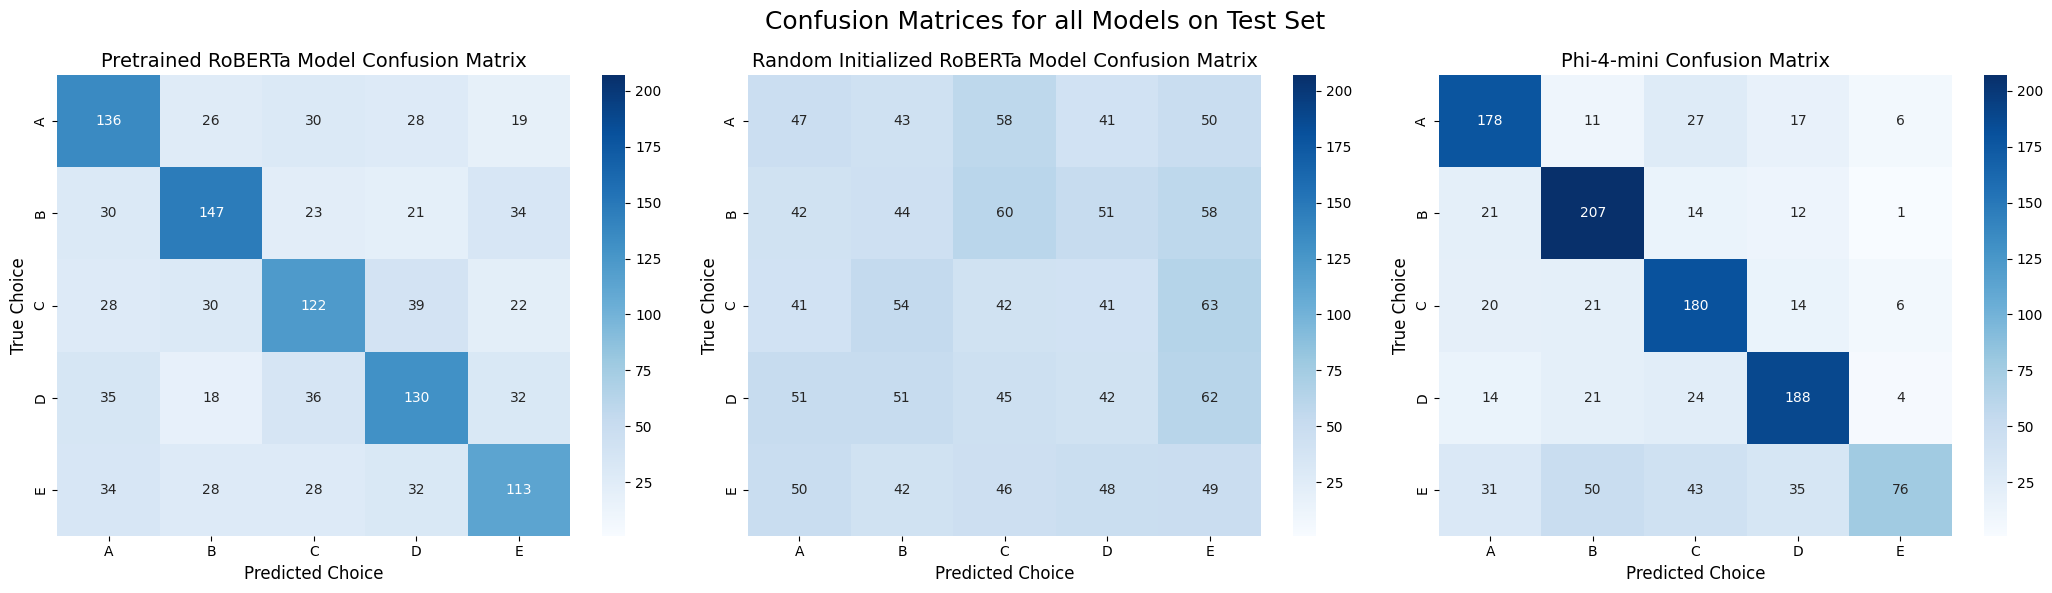

In [ ]:
os.makedirs("graphics", exist_ok=True)

label_mapping = {i: chr(65 + i) for i in range(5)}  # 0->A, 1->B, etc.
label_names = list(label_mapping.values())

pretrained_cm = confusion_matrix(pretrained_test_labels, pretrained_test_preds)
random_cm = confusion_matrix(random_test_labels, random_test_preds)
phi_cm = confusion_matrix(phi_test_labels, phi_test_preds)

# Determine the global min and max values for consistent scaling
global_vmin = min(pretrained_cm.min(), random_cm.min(), phi_cm.min())
global_vmax = max(pretrained_cm.max(), random_cm.max(), phi_cm.max())

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))

# Plot confusion matrices
sns.heatmap(pretrained_cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_names, yticklabels=label_names, 
            ax=ax1, vmin=global_vmin, vmax=global_vmax)
ax1.set_title("Pretrained RoBERTa Model Confusion Matrix", fontsize=14)
ax1.set_xlabel("Predicted Choice", fontsize=12)
ax1.set_ylabel("True Choice", fontsize=12)

sns.heatmap(random_cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_names, yticklabels=label_names, 
            ax=ax2, vmin=global_vmin, vmax=global_vmax)
ax2.set_title("Random Initialized RoBERTa Model Confusion Matrix", fontsize=14)
ax2.set_xlabel("Predicted Choice", fontsize=12)
ax2.set_ylabel("True Choice", fontsize=12)

sns.heatmap(phi_cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_names, yticklabels=label_names, 
            ax=ax3, vmin=global_vmin, vmax=global_vmax)
ax3.set_title("Phi-4-mini Confusion Matrix", fontsize=14)
ax3.set_xlabel("Predicted Choice", fontsize=12)
ax3.set_ylabel("True Choice", fontsize=12)

fig.suptitle("Confusion Matrices for all Models on Test Set", fontsize=18)
plt.tight_layout()
plt.savefig("graphics/confusion_matrices_all_models.svg", bbox_inches="tight")
plt.show()

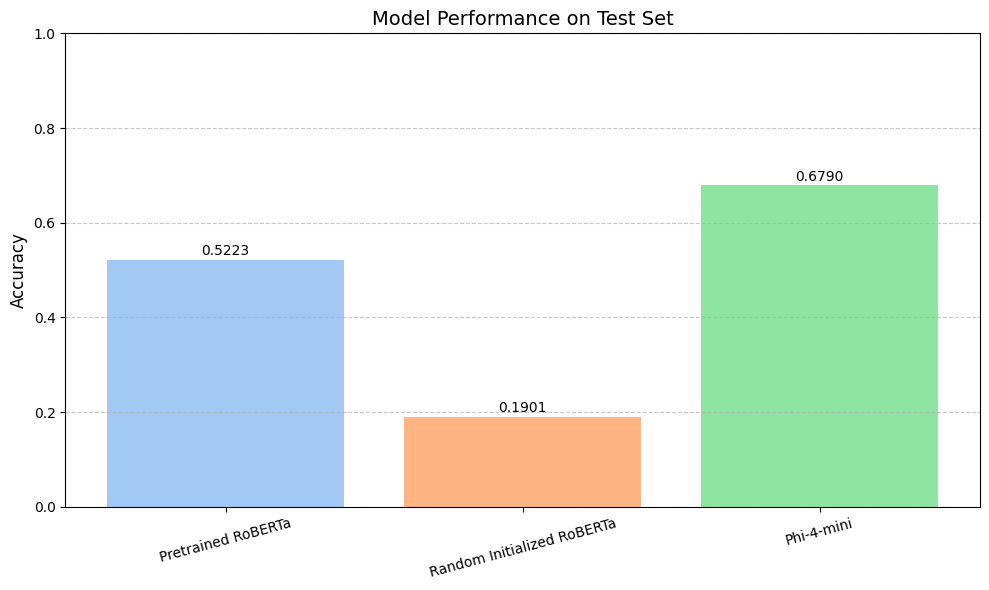

In [ ]:
# Create a bar chart to compare model performance
model_names = ['Pretrained RoBERTa', 'Random Initialized RoBERTa', 'Phi-4-mini']
accuracies = [
    pretrained_test_results[0]['test_acc'],
    random_test_results[0]['test_acc'],
    phi_test_accuracy
]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=sns.color_palette("pastel"))
plt.ylim(0, 1.0)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Performance on Test Set', fontsize=14)
plt.xticks(rotation=15)

# Add the accuracy values on top of the bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2., 
             bar.get_height() + 0.01, 
             f'{acc:.4f}', 
             ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('graphics/model_comparison.svg', bbox_inches='tight')
plt.show()

### Error Analysis

Since the randomly initialized model did't seem to learn anything at all and just predicted randomly, I won't do any error analysis on it.
I therefore only analyze the pre-trained Transformer and the LLM.

#### LLM Raw Answers

In [23]:
# get the indices of the answers where the model wrote a raw answer with more than 1 character
phi_long_answers = [(i, answer) for i, answer in enumerate(phi_test_raw_answers) if len(answer) > 1]
correct_answers = [(i, answer) for i, answer in phi_long_answers if phi_test_preds[i] == phi_test_labels[i]]
wrong_answers = [(i, answer) for i, answer in phi_long_answers if phi_test_preds[i] != phi_test_labels[i]]

print(f"Number of answers with more than 1 character: {len(phi_long_answers)}")
print(f"Number of correct answers: {len(correct_answers)}")
print(f"Number of wrong answers: {len(wrong_answers)}")
print()

for i, answer in phi_long_answers:
    print(f"Model's Answer: '{answer}'")
    print(f"Prompt: {phi_prompt_test[i]['prompt'][-1]}")
    print(f"Correct Answer: {index_to_answer_key(phi_test_labels[i])}")
    print(f"Predicted Answer: {index_to_answer_key(phi_test_preds[i])}")
    print()

Number of answers with more than 1 character: 389
Number of correct answers: 245
Number of wrong answers: 144

Model's Answer: 'A - complete job'
Prompt: {'role': 'user', 'content': 'Question: What do people aim to do at work?\nChoices:\nA - complete job\nB - learn from each other\nC - kill animals\nD - wear hats\nE - talk to each other'}
Correct Answer: A
Predicted Answer: A

Model's Answer: 'B - bookstore'
Prompt: {'role': 'user', 'content': 'Question: Where would you find magazines along side many other printed works?\nChoices:\nA - doctor\nB - bookstore\nC - market\nD - train station\nE - mortuary'}
Correct Answer: B
Predicted Answer: B

Model's Answer: 'A, B,'
Prompt: {'role': 'user', 'content': 'Question: James was looking for a good place to buy farmland.  Where might he look?\nChoices:\nA - midwest\nB - countryside\nC - estate\nD - farming areas\nE - illinois'}
Correct Answer: A
Predicted Answer: A

Model's Answer: 'A - farm house'
Prompt: {'role': 'user', 'content': "Question:

#### Patterns by Question Type

In [116]:
categories = {
    "location": ["where", "location", "place", "city", "country", "state"],
    "cause_effect": ["why", "because", "cause", "effect", "result", "reason", "consequence", "outcome"],
    "comparison": ["compared", "difference", "similar", "unlike", "similarity", "contrast", "comparison", "than"],
    "temporal": ["when", "before", "after", "during", "time", "day", "month", "year", "hour", "minute", "second"],
    "definition": ["what is", "define", "meaning", "definition", "describe", "explain", "characteristic", "feature"],
}

def categorize_questions(examples):
    categorized = []
    for ex in examples:
        question = ex["question"].lower()
        found_categories = []
        
        for category, keywords in categories.items():
            if any(keyword in question for keyword in keywords):
                found_categories.append(category)
        
        if not found_categories:
            found_categories = ["other"]
            
        categorized.append((ex, found_categories))
    
    return categorized

# Apply to test dataset
categorized_test = categorize_questions(test)

In [117]:
def analyze_by_question_type(test_predictions, categorized_questions):
  category_results = {cat: {"correct": 0, "total": 0} for cat in categories.keys()}
  category_results["other"] = {"correct": 0, "total": 0}

  for (ex, cats), pred_idx in zip(categorized_questions, test_predictions):
      true_idx = answer_key_to_index(ex["answerKey"])
      for cat in cats:
          category_results[cat]["total"] += 1
          if pred_idx == true_idx:
              category_results[cat]["correct"] += 1

  return category_results

roberta_question_type_results = analyze_by_question_type(pretrained_test_preds, categorized_test)
phi_question_type_results = analyze_by_question_type(phi_test_preds, categorized_test)

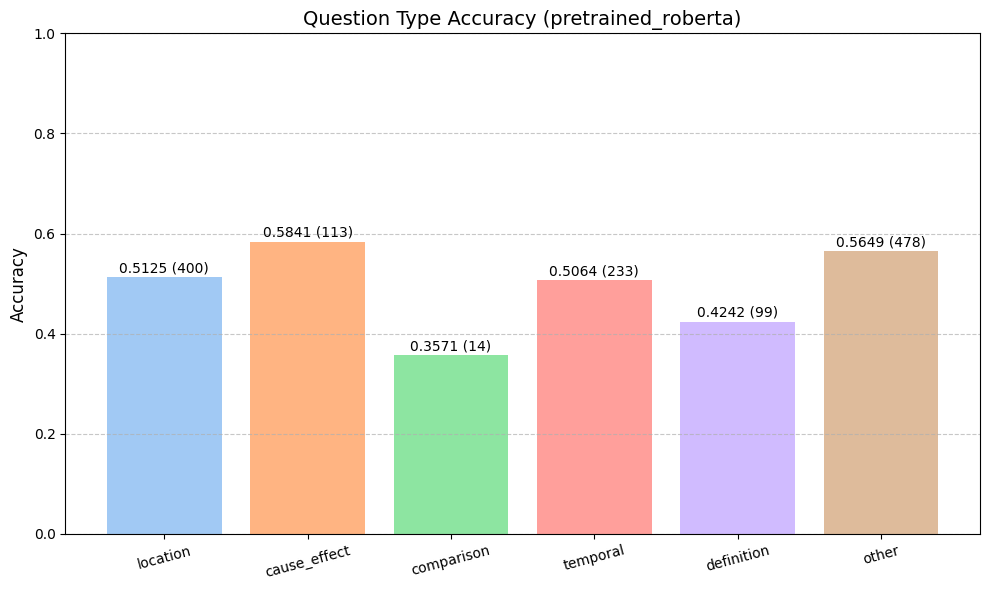

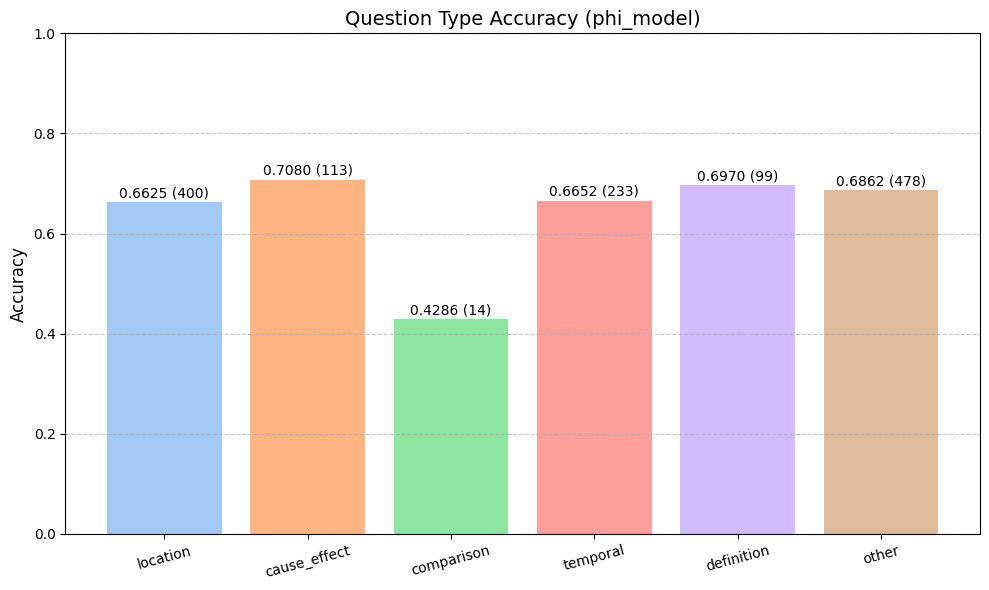

In [118]:
def plot_question_type_analysis(results, model_name):
    categories = list(results.keys())
    accuracies = [results[cat]["correct"] / results[cat]["total"] if results[cat]["total"] > 0 else 0 for cat in categories]
    counts = [results[cat]["total"] for cat in categories]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(categories, accuracies, color=sns.color_palette("pastel"))
    plt.ylim(0, 1.0)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title(f"Question Type Accuracy ({model_name})", fontsize=14)
    plt.xticks(rotation=15)

    # Add the accuracy values on top of the bars
    for bar, acc, count in zip(bars, accuracies, counts):
        plt.text(bar.get_x() + bar.get_width()/2.,
                 bar.get_height() + 0.01, 
                 f'{acc:.4f} ({count})', 
                 ha='center')

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'graphics/{model_name}_question_type_analysis.svg', bbox_inches='tight')
    plt.show()

plot_question_type_analysis(roberta_question_type_results, "pretrained_roberta")
plot_question_type_analysis(phi_question_type_results, "phi_model")

#### Question Length Impact

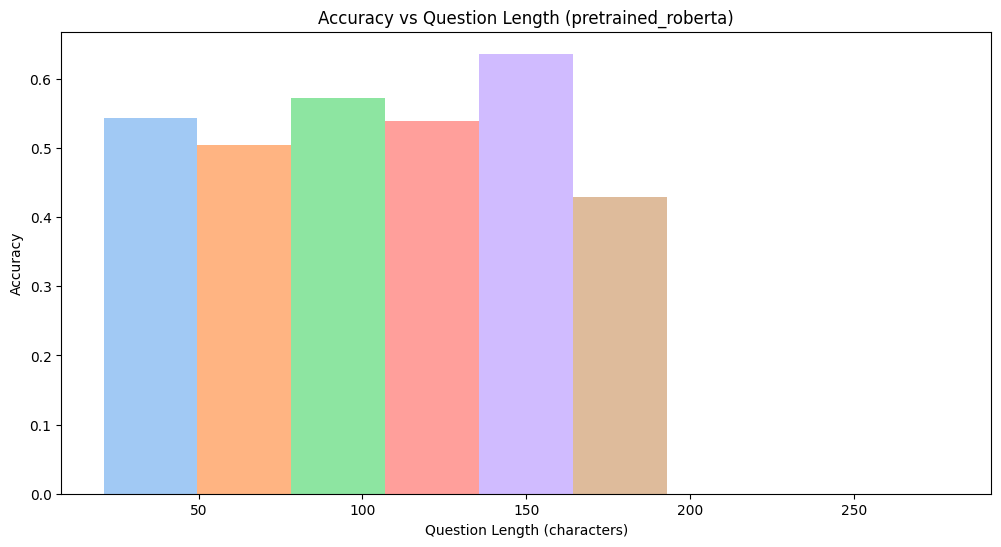

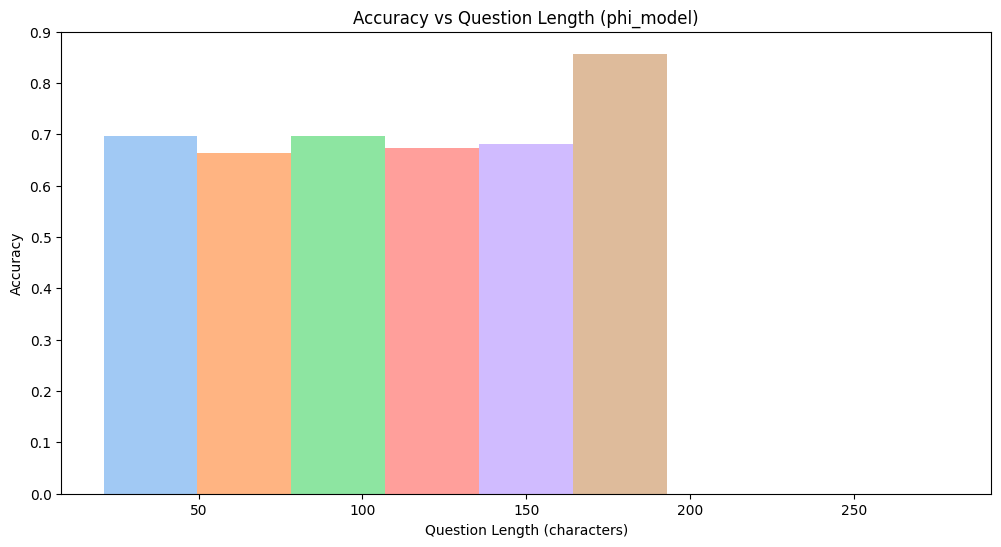

In [119]:
def analyze_by_question_length(test_data, preds, correct_answers, model_name):
    # Calculate lengths
    question_lengths = [len(ex["question"]) for ex in test_data]
    
    # Create length bins (e.g., 0-50, 50-100, etc.)
    bins = np.linspace(min(question_lengths), max(question_lengths), 10)
    digitized = np.digitize(question_lengths, bins)
    
    # Calculate accuracy per bin
    bin_correct = np.zeros(len(bins))
    bin_total = np.zeros(len(bins))
    
    for (length_bin, pred, true) in zip(digitized, preds, correct_answers):
        bin_total[length_bin-1] += 1
        if pred == true:
            bin_correct[length_bin-1] += 1
    
    # Calculate accuracy per bin
    bin_accuracy = np.divide(bin_correct, bin_total, out=np.zeros_like(bin_correct), where=bin_total != 0)
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(bins[:-1], bin_accuracy[:-1], width=np.diff(bins), align='edge', color=sns.color_palette("pastel"))
    plt.xlabel('Question Length (characters)')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs Question Length ({model_name})')
    plt.savefig(f'graphics/{model_name}_accuracy_vs_length.svg')
    plt.show()

analyze_by_question_length(test, pretrained_test_preds, pretrained_test_labels, "pretrained_roberta")
analyze_by_question_length(test, phi_test_preds, phi_test_labels, "phi_model")

### Answer Choice Bias

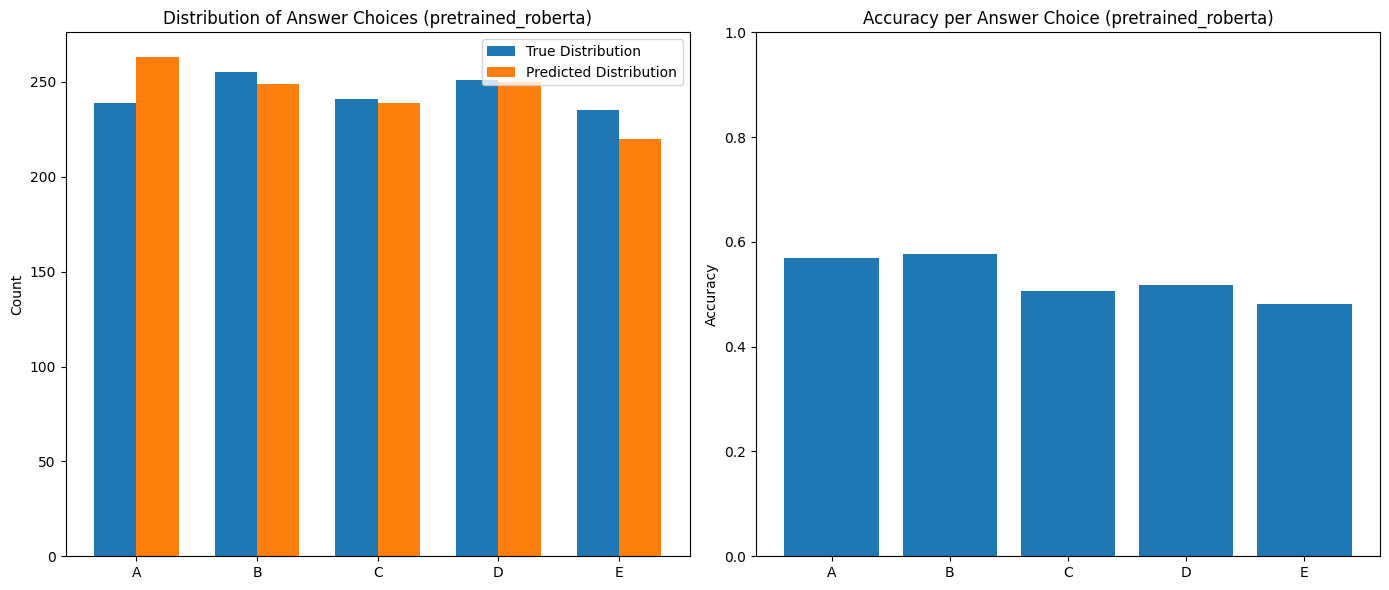

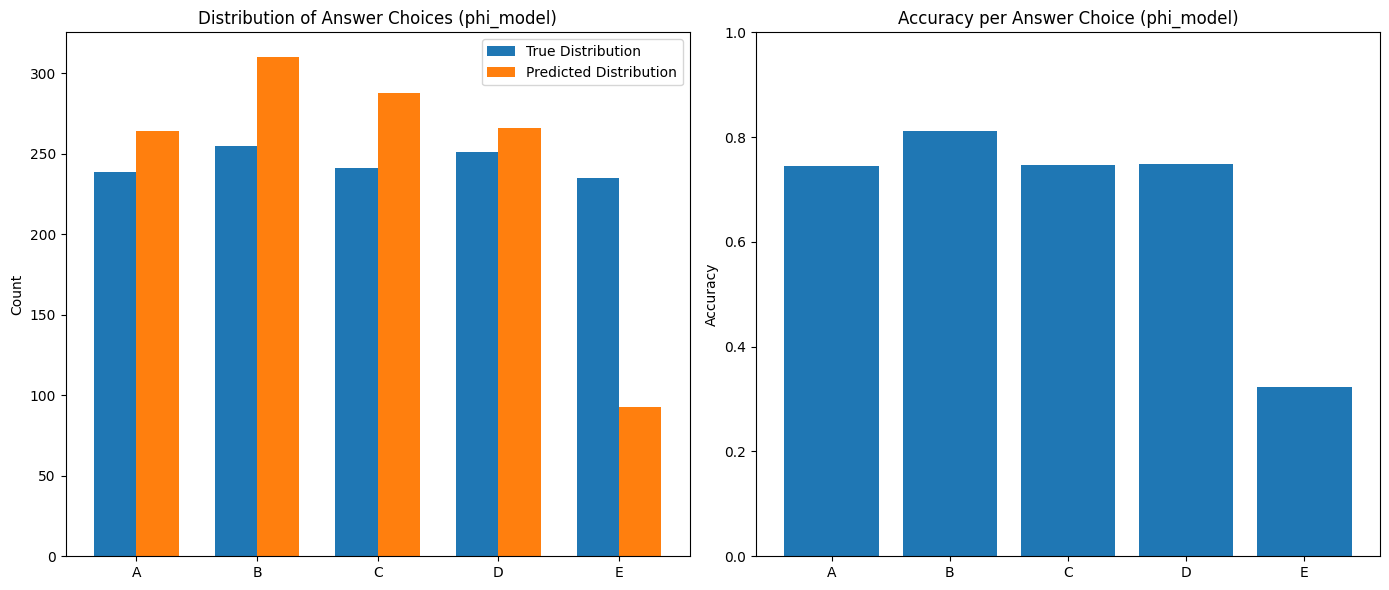

In [120]:
def analyze_answer_choice_bias(preds, true_labels, model_name):
    # Count predictions and correct answers per choice
    pred_counts = [0, 0, 0, 0, 0]  # A, B, C, D, E
    true_counts = [0, 0, 0, 0, 0]
    correct_counts = [0, 0, 0, 0, 0]
    
    for pred, true in zip(preds, true_labels):
        pred_counts[pred] += 1
        true_counts[true] += 1
        if pred == true:
            correct_counts[true] += 1
    
    # Calculate accuracy per choice
    choice_accuracy = []
    for i in range(5):
        acc = correct_counts[i] / true_counts[i] if true_counts[i] > 0 else 0
        choice_accuracy.append(acc)
    
    # Plot
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Distribution of predictions vs ground truth
    labels = ['A', 'B', 'C', 'D', 'E']
    x = np.arange(len(labels))
    width = 0.35
    
    ax1.bar(x - width/2, true_counts, width, label='True Distribution')
    ax1.bar(x + width/2, pred_counts, width, label='Predicted Distribution')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels)
    ax1.set_ylabel('Count')
    ax1.set_title(f'Distribution of Answer Choices ({model_name})')
    ax1.legend()
    
    # Accuracy per answer choice
    ax2.bar(labels, choice_accuracy)
    ax2.set_ylim(0, 1)
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'Accuracy per Answer Choice ({model_name})')
    
    plt.tight_layout()
    plt.savefig(f'graphics/{model_name}_answer_choice_analysis.svg')
    plt.show()

analyze_answer_choice_bias(pretrained_test_preds, pretrained_test_labels, "pretrained_roberta")
analyze_answer_choice_bias(phi_test_preds, phi_test_labels, "phi_model")

#### Model Confidence (for Transformer)

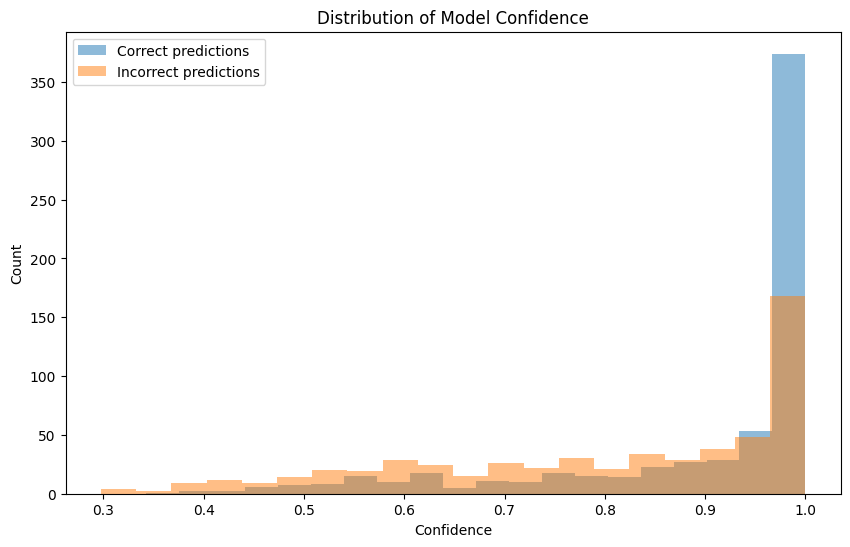

Average confidence for correct predictions: 0.9034
Average confidence for incorrect predictions: 0.8033


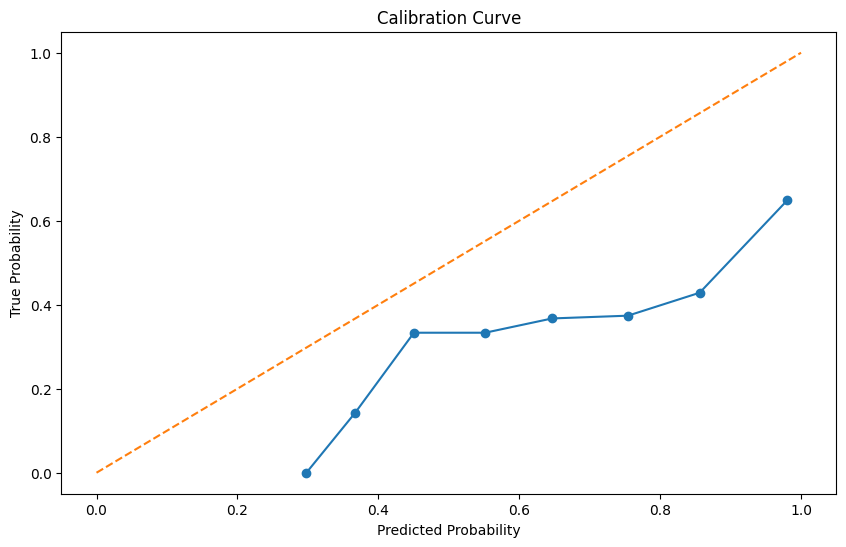

In [123]:
def analyze_confidence(preds, confidences, true_labels):
    correct = [conf for pred, conf, true in zip(preds, confidences, true_labels) if pred == true]
    incorrect = [conf for pred, conf, true in zip(preds, confidences, true_labels) if pred != true]
    
    plt.figure(figsize=(10, 6))
    plt.hist(correct, alpha=0.5, label='Correct predictions', bins=20)
    plt.hist(incorrect, alpha=0.5, label='Incorrect predictions', bins=20)
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.title('Distribution of Model Confidence')
    plt.legend()
    plt.savefig('graphics/confidence_distribution.svg')
    plt.show()
    
    print(f"Average confidence for correct predictions: {np.mean(correct):.4f}")
    print(f"Average confidence for incorrect predictions: {np.mean(incorrect):.4f}")
    
    # Calculate calibration
    from sklearn.calibration import calibration_curve
    
    is_correct = [1 if pred == true else 0 for pred, true in zip(preds, true_labels)]
    prob_true, prob_pred = calibration_curve(is_correct, confidences, n_bins=10)
    
    plt.figure(figsize=(10, 6))
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title('Calibration Curve')
    plt.savefig('graphics/calibration_curve.svg')
    plt.show()

analyze_confidence(pretrained_test_preds, pretrained_test_confidences, pretrained_test_labels) 

#### Diffcult Examples

In [122]:
def find_challenging_examples(test_data, model1_preds, model2_preds, true_labels):
    # Find examples where both models got wrong
    challenging = []
    
    for i, (ex, pred1, pred2, true) in enumerate(zip(test_data, model1_preds, model2_preds, true_labels)):
        if pred1 != true and pred2 != true:
            # Both models wrong
            challenging.append((i, ex))
    
    return challenging

challenging_examples = find_challenging_examples(test, pretrained_test_preds, phi_test_preds, pretrained_test_labels)

print(f"Found {len(challenging_examples)} examples that both models got wrong")

# Examine a few challenging examples
print("\nSample of challenging examples:")
for i, (idx, ex) in enumerate(challenging_examples[:10]):
    print(f"\nExample {i+1}:")
    print(f"Question: {ex['question']}")
    for j, choice in enumerate(ex['choices']['text']):
        print(f"{chr(65+j)}) {choice}")
    print(f"Correct Answer: {ex['answerKey']}")
    print(f"RoBERTa prediction: {index_to_answer_key(pretrained_test_preds[idx])}")
    print(f"Phi-4 prediction: {index_to_answer_key(phi_test_preds[idx])}")

Found 245 examples that both models got wrong

Sample of challenging examples:

Example 1:
Question: James was looking for a good place to buy farmland.  Where might he look?
A) midwest
B) countryside
C) estate
D) farming areas
E) illinois
Correct Answer: A
RoBERTa prediction: B
Phi-4 prediction: D

Example 2:
Question: What do people typically do while playing guitar?
A) cry
B) hear sounds
C) singing
D) arthritis
E) making music
Correct Answer: C
RoBERTa prediction: E
Phi-4 prediction: E

Example 3:
Question: Aside from water and nourishment what does your dog need?
A) bone
B) charm
C) petted
D) lots of attention
E) walked
Correct Answer: D
RoBERTa prediction: C
Phi-4 prediction: C

Example 4:
Question: A fencing thrust with a sharp sword towards a person would result in what?
A) injury
B) small cuts
C) fever
D) competition
E) puncture wound
Correct Answer: E
RoBERTa prediction: B
Phi-4 prediction: A

Example 5:
Question: Though the thin film seemed fragile, for it's intended purpose 

## Interpretation

## Tools Used

- Visual Studio Code as IDE
- Jupyter Notebook for interactive development
- Python 3.9.21
- GitHub for version control
- Weights & Biases for experiment tracking and hyperparameter optimization
- Claude 3.7 Sonnet for troubleshooting, finding bugs and discussing ideas
- Github Copilot Chat for troubleshooting and finding bugs